In [18]:
!pip install folium

     |████████████████████████████████| 94 kB 2.6 MB/s eta 0:00:011


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Recommendations for Lyft Bay Wheel In-app Offers 

In [2]:
%%bigquery hourly_trip_freq_weekday

SELECT EXTRACT(hour from start_date) AS start_hour, COUNT(*) AS number_of_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(dayofweek from start_date) BETWEEN 2 AND 6
GROUP BY start_hour
ORDER BY start_hour

Downloading: 100%|██████████| 24/24 [00:01<00:00, 15.65rows/s]


In [3]:
%%bigquery hourly_trip_freq_weekend

SELECT EXTRACT(hour from start_date) AS start_hour, COUNT(*) AS number_of_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(dayofweek from start_date) NOT BETWEEN 2 AND 6
GROUP BY start_hour
ORDER BY start_hour

Downloading: 100%|██████████| 24/24 [00:01<00:00, 16.30rows/s]


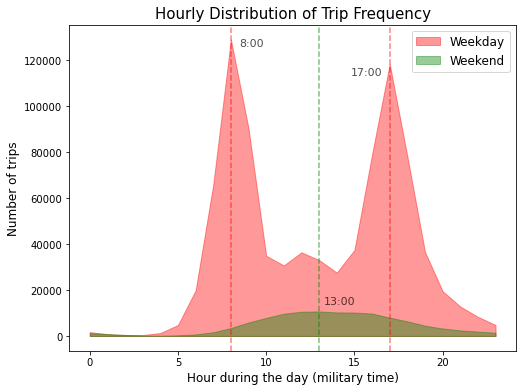

In [4]:
peak_weekday = hourly_trip_freq_weekday.sort_values('number_of_trips', ascending=False).iloc[0,0]
peak_2_weekday = hourly_trip_freq_weekday.sort_values('number_of_trips', ascending=False).iloc[1,0]
peak_weekend = hourly_trip_freq_weekend.sort_values('number_of_trips', ascending=False).iloc[0,0]

fig = plt.figure(figsize=(8,6))
plt.title("Hourly Distribution of Trip Frequency", fontsize=15)
plt.xlabel("Hour during the day (military time)", fontsize=12)
plt.ylabel("Number of trips", fontsize=12)
plt.fill_between(hourly_trip_freq_weekday['start_hour'], hourly_trip_freq_weekday['number_of_trips'], label='Weekday', color='red', alpha=.4)
plt.fill_between(hourly_trip_freq_weekend['start_hour'], hourly_trip_freq_weekend['number_of_trips'], label='Weekend', color='green', alpha=.4)
plt.axvline(peak_weekday,color='red', alpha=0.5, linestyle='dashed')
plt.axvline(peak_2_weekday,color='red', alpha=0.5, linestyle='dashed')
plt.axvline(peak_weekend,color='green', alpha=0.5, linestyle='dashed')
plt.text(peak_weekday+0.5, hourly_trip_freq_weekday['number_of_trips'].max()-3000, '{}:00'.format(peak_weekday), alpha=0.7, fontsize=11)
plt.text(peak_2_weekday-2.2, hourly_trip_freq_weekday.sort_values('number_of_trips', ascending=False).iloc[1,1]-5000, '{}:00'.format(peak_2_weekday), alpha=0.7, fontsize=11)
plt.text(peak_weekend+0.25, hourly_trip_freq_weekend['number_of_trips'].max()+3000, '{}:00'.format(peak_weekend), alpha=0.7, fontsize=11)
plt.legend(fontsize=12);

### What does this graph show us?
1. Most riders use our bikes during weekdays (Monday-Friday).
2. Weekday riders use our bikes the most in the morning (around 8am) or in the afternoon (around 5pm), while weekend riders usually use the bikes in the middle of the day (around 1pm).
3. Peak hours during weekdays resemble work commute peak hours.

**This suggests that most riders use Lyft Bay Wheels during weekdays to commute to work, so my recommendation for in-app offers will target commuters. This motivates the next question...**

## 1. What are the 5 most popular trips that you would call "commuter trips"?

1. 2nd at Townsend $\rightarrow$ Harry Bridges Plaza (Ferry Building)
2. Harry Bridges Plaza (Ferry Building) $\rightarrow$ 2nd at Townsend
3. San Francisco Caltrain 2 (330 Townsend) $\rightarrow$ Townsend at 7th
4. Embarcadero at Sansome $\rightarrow$ Steuart at Market
5. Embarcadero at Folsom $\rightarrow$ San Francisco Caltrain (Townsend at 4th)

### 1a. Defining Commuter Trips and Identifying the 5 Most Popular Commuter Trips

We define commuters as people who travel to work on a regular basis. Since people usually only work on weekdays (Monday-Friday), using the graph shown above, we define commuter trips as one way trips$^{[1]}$ that occur during morning peak hours from 7am up to 10am and afternoon peak hours from 4pm up to 7pm on weekdays.

[1] Round trips were not excluded in subsequent queries for commuter trips, but none of the popular trips were round trips.

In [5]:
%%bigquery most_pop_trips

SELECT start_station_name, end_station_name, COUNT(*) AS number_of_trips,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(dayofweek from start_date) BETWEEN 2 AND 6 AND (EXTRACT(hour from start_date) BETWEEN 7 AND 9 OR EXTRACT(hour from start_date) BETWEEN 16 AND 18)
GROUP BY start_station_name, end_station_name ORDER BY number_of_trips DESC LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.14rows/s]


In [6]:
most_pop_trips

,start_station_name,end_station_name,number_of_trips
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5165
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5127
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5040
3,Embarcadero at Sansome,Steuart at Market,4904
4,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4756


The table above shows the 5 most popular commuter trips that began either during morning or afternoon peak hours. To verify they are commuter trips, we look at whether each of those trips has mirroring trip patterns between morning peak hours and afternoon peak hours. From the table below, we can see that all of these station pairs have mirroring trips between morning and afternoon peak hours, and on top of that, they are all within the top 10 most popular trips during their respective peak hours. This further confirms that the 5 most popular trips shown above are commuter trips.

In [7]:
%%bigquery am_peak_trips

SELECT start_station_name, end_station_name, COUNT(*) AS number_of_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE EXTRACT(dayofweek from start_date) BETWEEN 2 AND 6 AND EXTRACT(hour from start_date) BETWEEN 7 AND 9
GROUP BY start_station_name, end_station_name ORDER BY number_of_trips DESC LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  8.49rows/s]


In [8]:
%%bigquery pm_peak_trips

SELECT start_station_name, end_station_name, COUNT(*) AS number_of_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(dayofweek from start_date) BETWEEN 2 AND 6 AND EXTRACT(hour from start_date) BETWEEN 16 AND 18
GROUP BY start_station_name, end_station_name ORDER BY number_of_trips DESC LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  5.90rows/s]


In [9]:
#combine morning and afternoon queries into one dataframe 
am_peak_trips = am_peak_trips.add_suffix("_AM")
pm_peak_trips = pm_peak_trips.add_suffix("_PM")
ampm_peak_trips = am_peak_trips.merge(pm_peak_trips, left_index=True, right_index=True)
ampm_peak_trips

,start_station_name_AM,end_station_name_AM,number_of_trips_AM,start_station_name_PM,end_station_name_PM,number_of_trips_PM
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4509,2nd at Townsend,Harry Bridges Plaza (Ferry Building),4191
1,Steuart at Market,2nd at Townsend,3759,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4022
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,3512,Embarcadero at Sansome,Steuart at Market,3863
3,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,3364,Steuart at Market,San Francisco Caltrain (Townsend at 4th),3393
4,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),3126,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),3326
5,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),2948,Market at 10th,San Francisco Caltrain 2 (330 Townsend),3279
6,Market at Sansome,2nd at South Park,2934,2nd at South Park,Market at Sansome,3183
7,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,2888,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),2798
8,San Francisco Caltrain (Townsend at 4th),Steuart at Market,2790,Howard at 2nd,San Francisco Caltrain (Townsend at 4th),2785
9,Steuart at Market,Embarcadero at Sansome,2777,Market at Sansome,San Francisco Caltrain (Townsend at 4th),2436


### 1b. Investigating Characteristics of the 5 Most Popular Commuter Trips

In order to make recommendation, we look at average trip durations of the 5 most popular commuter trips and user subscription type.

#### Trip Duration & Location

In [10]:
%%bigquery trip_locs

WITH trips_and_stations AS
  (WITH start_loc_trips AS
    (SELECT `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_name, `bigquery-public-data.san_francisco.bikeshare_trips`.end_station_name, COUNT(*) AS number_of_trips,
     `bigquery-public-data.san_francisco.bikeshare_stations`.longitude AS start_lon, `bigquery-public-data.san_francisco.bikeshare_stations`.latitude AS start_lat
     FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
     INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` ON `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_name=`bigquery-public-data.san_francisco.bikeshare_stations`.name
     WHERE EXTRACT(dayofweek from `bigquery-public-data.san_francisco.bikeshare_trips`.start_date) BETWEEN 2 AND 6 AND
     (EXTRACT(hour from `bigquery-public-data.san_francisco.bikeshare_trips`.start_date) BETWEEN 7 AND 9 OR EXTRACT(hour from `bigquery-public-data.san_francisco.bikeshare_trips`.start_date) BETWEEN 16 AND 18)
     GROUP BY start_station_name, end_station_name, start_lon, start_lat)
  SELECT start_loc_trips.start_station_name, start_loc_trips.end_station_name, start_loc_trips.number_of_trips, start_loc_trips.start_lon, start_loc_trips.start_lat,
  `bigquery-public-data.san_francisco.bikeshare_stations`.longitude AS end_lon, `bigquery-public-data.san_francisco.bikeshare_stations`.latitude AS end_lat
  FROM start_loc_trips
  INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` ON start_loc_trips.end_station_name=`bigquery-public-data.san_francisco.bikeshare_stations`.name
  WHERE start_loc_trips.start_station_name != start_loc_trips.end_station_name)
SELECT start_station_name, end_station_name, number_of_trips, start_lat, start_lon, end_lat, end_lon FROM trips_and_stations
ORDER BY number_of_trips DESC LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.62rows/s]


In [11]:
geo_map = folium.Map(location=[37.791464, -122.390661], zoom_start=14, width='70%', height='80%')
stations_recorded = set()
for i in range(trip_locs.shape[0]):
    #stations_recorded.add()
    start_lat, start_lon = trip_locs.loc[i, 'start_lat'], trip_locs.loc[i, 'start_lon']
    station_name = trip_locs.loc[i, 'start_station_name']
    folium.Marker(location=[start_lat, start_lon], tooltip=station_name, icon=folium.Icon(color="pink", icon="bicycle", prefix="fa")).add_to(geo_map)
    end_lat, end_lon = trip_locs.loc[i, 'end_lat'], trip_locs.loc[i, 'end_lon']
    station_name = trip_locs.loc[i, 'end_station_name']
    folium.Marker(location=[end_lat, end_lon], tooltip=station_name, icon=folium.Icon(color="pink", icon="bicycle", prefix="fa")).add_to(geo_map)
    path = [(start_lat, start_lon), (end_lat, end_lon)]
    folium.PolyLine(path, color='green', weight=5, opacity=0.6).add_to(geo_map)
geo_map

The map above provides a geospatial representation of where the stations of the most 5 popular trips locate as well as the Euclidean distance of those trips. The pink markers denote the locations of the stations for the 5 most popular trips. The green lines indicate that there is a trip between thw two stations that are connected, but it does not indicate the exact route taken. The line between 2nd at Townsend and Harry Bridges Plaza (Ferry Building) is darker because there are two trips in between those two stations- one from 2nd at Townsend to Harry Bridges Plaza (Ferry Building) and one going the opposite direction.

##### What does the graph tell us?
1. The 5 most popular commuter trips are taken in Embarcadero, which is close to the Financial District, and SOMA.
2. All the trips are at least 3 blocks long.

In [79]:
%%bigquery trip_duration_stats

SELECT 
FORMAT(
'%i days %i hours %i minutes %i seconds',
unix_date(date(timestamp_seconds(CAST(ROUND(AVG(duration_sec)) AS int)))),
EXTRACT(hour from timestamp_seconds(CAST(ROUND(AVG(duration_sec)) AS int))),
EXTRACT(minute from timestamp_seconds(CAST(ROUND(AVG(duration_sec)) AS int))),
EXTRACT(second from timestamp_seconds(CAST(ROUND(AVG(duration_sec)) AS int)))) AS duration_mean,
FORMAT(
'%i days %i hours %i minutes %i seconds',
unix_date(date(timestamp_seconds(CAST(ROUND(STDDEV_SAMP(duration_sec)) AS int)))),
EXTRACT(hour from timestamp_seconds(CAST(ROUND(STDDEV_SAMP(duration_sec)) AS int))),
EXTRACT(minute from timestamp_seconds(CAST(ROUND(STDDEV_SAMP(duration_sec)) AS int))),
EXTRACT(second from timestamp_seconds(CAST(ROUND(STDDEV_SAMP(duration_sec)) AS int)))) AS duration_stddev
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(dayofweek from start_date) BETWEEN 2 AND 6 AND (EXTRACT(hour from start_date) BETWEEN 7 AND 9 OR EXTRACT(hour from start_date) BETWEEN 16 AND 18) AND
      duration_sec < 86400

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.42s/rows]


In [150]:
trip_duration_stats

,duration_mean,duration_stddev
0,0 days 0 hours 11 minutes 6 seconds,0 days 0 hours 30 minutes 16 seconds


In [151]:
%%bigquery trip_dist

WITH trips_and_stations AS
  (WITH start_loc_trips AS
    (SELECT `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_name, `bigquery-public-data.san_francisco.bikeshare_trips`.end_station_name, 
     COUNT(*) AS number_of_trips, AVG(`bigquery-public-data.san_francisco.bikeshare_trips`.duration_sec) AS mean_duration_sec,
     `bigquery-public-data.san_francisco.bikeshare_stations`.longitude AS start_lon, `bigquery-public-data.san_francisco.bikeshare_stations`.latitude AS start_lat
     FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
     INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` ON `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_name=`bigquery-public-data.san_francisco.bikeshare_stations`.name
     WHERE EXTRACT(dayofweek from `bigquery-public-data.san_francisco.bikeshare_trips`.start_date) BETWEEN 2 AND 6 AND
     (EXTRACT(hour from `bigquery-public-data.san_francisco.bikeshare_trips`.start_date) BETWEEN 7 AND 9 OR EXTRACT(hour from `bigquery-public-data.san_francisco.bikeshare_trips`.start_date) BETWEEN 16 AND 18)
     GROUP BY start_station_name, end_station_name, start_lon, start_lat)
  SELECT start_loc_trips.start_station_name, start_loc_trips.end_station_name, start_loc_trips.number_of_trips, start_loc_trips.mean_duration_sec, start_loc_trips.start_lon, start_loc_trips.start_lat,
  `bigquery-public-data.san_francisco.bikeshare_stations`.longitude AS end_lon, `bigquery-public-data.san_francisco.bikeshare_stations`.latitude AS end_lat
  FROM start_loc_trips
  INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` ON start_loc_trips.end_station_name=`bigquery-public-data.san_francisco.bikeshare_stations`.name
  WHERE start_loc_trips.start_station_name != start_loc_trips.end_station_name)
SELECT start_station_name, end_station_name, number_of_trips, mean_duration_sec, ST_DISTANCE(ST_GEOGPOINT(start_lon, start_lat), ST_GEOGPOINT(end_lon, end_lat)) AS trip_dist_meter FROM trips_and_stations
ORDER BY number_of_trips DESC LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.22rows/s]


In [155]:
%%bigquery popular_avg_duration

SELECT start_station_name, end_station_name, COUNT(*) AS number_of_trips, 
FORMAT(
    '%i minutes %i seconds',
    EXTRACT(minute from timestamp_seconds(CAST(ROUND(AVG(duration_sec)) AS int))),
    EXTRACT(second from timestamp_seconds(CAST(ROUND(AVG(duration_sec)) AS int)))) AS mean_duration_sec
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(dayofweek from start_date) BETWEEN 2 AND 6 AND (EXTRACT(hour from start_date) BETWEEN 7 AND 9 OR EXTRACT(hour from start_date) BETWEEN 16 AND 18) AND
    duration_sec BETWEEN 165 AND 4298
GROUP BY start_station_name, end_station_name ORDER BY number_of_trips DESC LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.23rows/s]


In [154]:
trip_duration_stats

,duration_mean,duration_stddev
0,0 days 0 hours 11 minutes 6 seconds,0 days 0 hours 30 minutes 16 seconds


In [157]:
trip_dist

,start_station_name,end_station_name,number_of_trips,mean_duration_sec,trip_dist_meter
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5165,499.033107,1688.447545
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5127,594.694558,1688.447545
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5040,280.467460,886.267329
3,Embarcadero at Sansome,Steuart at Market,4904,432.255506,1412.519853
4,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4756,642.895500,1692.170435


In calculating the average trip duration, we want to exclude trips with anomalous trip durations because those are likely user errors. For example, someone could have forgotten to return a bike when they went to work and created a record that lasted the whole day. To set the lower bound, we first derive the shortest distance of the shortest trip among the 5 most popular trips, which is around 886 meters. This distance is a lower bound on the actual trip distance, since in reality riders would not be able to travel in a straight line from one station to another. Using the average bicycle speed of 12mph in St. Petersburg, Florida in 2009 as an estimate of how fast commuters bike, the shortest trip distance of the 5 most popular commuter trips (886.27m) takes an average biker 2 minutes and 45 seconds, or 165.35 seconds, to complete. We set the upper bound as 2 standard deviations above the average trip duration, which is 1 hour 11 minutes and 38 seconds, or 4298 seconds.

Using the lower and upper bound aforementioned, the average trip duration for each of the 5 most popular commuter trips is less than or about 10 minutes.

[2] [An Examination of Bicycle Counts and Speeds Associated with the Installation of Bike Lanes in St. Petersburg, Florida](https://www.pedbikeinfo.org/cms/downloads/FDOT_BA784_ExaminationBicycleCountsSpeedsInstallationBikeLanesStPetersburgFlorida.pdf)

In [156]:
popular_avg_duration

,start_station_name,end_station_name,number_of_trips,mean_duration_sec
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5164,8 minutes 18 seconds
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5121,9 minutes 42 seconds
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5011,4 minutes 15 seconds
3,Embarcadero at Sansome,Steuart at Market,4895,6 minutes 41 seconds
4,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4752,10 minutes 10 seconds


### Ridership Demographic: Subscription Type

Here we investigate the subscription type of riders who start trips during peak hours on weekdays versus on weekends.

Over 95% of commuters of the 10 most popular trips are subscribers. To ensure that this is not simply a phenomenon of having more subscribers (86%) than customers (14%) in the dataset, I investigated subscriber types of trips made during weekend peak hours since commuters typically only make trips for commuting purposes during weekdays. The proportion of subscribers during weekend peak hours mirrors those during weekday peak hours. For each of the 5 most popular trips during weekend peak hours, over 60% of their trips are completed by customers. 

This shows that:
* most commuters are subscribers.
* most riders during peak hours on weekends are customers.

In [163]:
%%bigquery subscriber_ratio

SELECT subscriber_type, COUNT(*) AS type_count, ROUND(COUNT(*)*100/983648, 1) AS percentage FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY subscriber_type

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.15rows/s]


In [168]:
%%bigquery commute_type

SELECT start_station_name, end_station_name, COUNT(*) AS number_of_trips,
ROUND(SUM(CASE WHEN subscriber_type="Subscriber" THEN 1 ELSE 0 END)/COUNT(*)*100,1) AS prop_subscribers FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(dayofweek from start_date) BETWEEN 2 AND 6 AND (EXTRACT(hour from start_date) BETWEEN 7 AND 9 OR EXTRACT(hour from start_date) BETWEEN 16 AND 18)
GROUP BY start_station_name, end_station_name ORDER BY number_of_trips DESC LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.94rows/s]


In [170]:
%%bigquery noncommute_type

SELECT start_station_name, end_station_name, COUNT(*) AS number_of_trips, 
ROUND(SUM(CASE WHEN subscriber_type="Subscriber" THEN 1 ELSE 0 END)/COUNT(*)*100,1) AS prop_subscribers
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(hour from start_date) BETWEEN 11 AND 16 AND EXTRACT(dayofweek from start_date) NOT BETWEEN 2 AND 6
GROUP BY start_station_name, end_station_name ORDER BY number_of_trips DESC LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.46rows/s]


In [169]:
commute_type

,start_station_name,end_station_name,number_of_trips,prop_subscribers
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5165,97.5
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5127,97.0
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5040,98.4
3,Embarcadero at Sansome,Steuart at Market,4904,95.6
4,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4756,98.5
5,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),4689,97.1
6,Steuart at Market,2nd at Townsend,4632,97.9
7,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),4584,98.5
8,Steuart at Market,San Francisco Caltrain (Townsend at 4th),4509,97.6
9,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),4258,98.5


In [171]:
noncommute_type

,start_station_name,end_station_name,number_of_trips,prop_subscribers
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,1406,14.2
1,Embarcadero at Sansome,Embarcadero at Sansome,797,4.3
2,Harry Bridges Plaza (Ferry Building),Harry Bridges Plaza (Ferry Building),743,9.2
3,Embarcadero at Sansome,Harry Bridges Plaza (Ferry Building),687,31.1
4,Embarcadero at Vallejo,Embarcadero at Sansome,412,5.1


## Recommendations for offers

1. Subscribers can ride e-bikes for free for the first 10 minutes on weekdays.

   * Subscribers can already ride regular bikes for free (up to 45 minutes), but they have to pay 15 cents per minute to ride the e-bike.
   * All 5 of the most popular commuter trips are less than or about 10 minutes long, and since most commuters are subscribers, offering subscribers the option to ride e-bikes for free for the typical commute duration on weekdays would encourage commuters to use our service even when they are feeling a bit too tired or lazy to ride bikes.

2. Offer membership discounts to those working/living in the Financial District, Embarcadero, or SOMA neighborhoods.

    * Commuters are usually subscribers, and those who are not would likely prefer membership due to regular use.
    * Since the 5 most popular trips are done in or near these areas, membership discounts would encourage a lot of commuters to start or continue using our service.

3. Offer discounts to Customers during the weekend from 11am to 5pm.
    * Most trips during the weekend are completed by customers.
    * 11am to 5pm is when most trips are occuring during weekends.